# Difftest Results

Import prereqs and connect to results database:

In [7]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
from labm8 import humanize

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import fs, viz

def cache_time(path):
    modified = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    diff = datetime.datetime.now() - modified
    return humanize.Duration(diff) + " ago ({})".format(modified)

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

TIME_LIMIT = 48 * 3600
TIMEOUT = 60

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

Summary of testing results:

In [8]:
!rm -fv ../data/difftest/overview.csv

removed '../data/difftest/overview.csv'


In [9]:
def get_device_stats(s, tables, testbed_id, no_opt):
    devname = device_str(s.query(Testbed).filter(Testbed.id == testbed_id).first().device)
    
    optimizations = not no_opt
    param_ids = s.query(tables.params.id)\
        .filter(tables.params.optimizations == optimizations)
    
    num_results = s.query(sql.sql.func.count(tables.results.id))\
        .join(tables.testcases)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.testcases.params_id.in_(param_ids)).scalar()

    total_time = int(s.query(tables.meta.cumtime)\
        .join(tables.results)\
        .join(tables.testcases)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.testcases.params_id.in_(param_ids))\
        .order_by(tables.meta.cumtime.desc()).first()[0])

    total_hours = total_time / 3600
    
    print(f"\r\033[1K{tables.name} {devname}",
          "no-opt" if no_opt else "opt",
          f"results: {num_results} time: {total_hours:.1f} hrs", end="")
    return num_results, total_time


def get_device_overview(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_device_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_device_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


def get_overview_table():
    cachepath = "../data/difftest/overview.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={
            "CLSmith time": np.int32, "CLgen time": np.int32,
            "CLSmith results": np.int32, "CLgen results": np.int32,
        })
    else:
        rows = []
        with Session(commit=False) as s:
            for config_id, testbed_id in CONFIGURATIONS:
                rows += get_device_overview(s, testbed_id)
        print("\r\033[1K", end="")
        table = pd.DataFrame(rows)
        table.to_csv(cachepath)
        return get_overview_table()


overview_table = get_overview_table()
overview_table

CLgen Oclgrind Simulator opt results: 135062 time: 88.1 hrshrsrs0 hrshrsscached now (2017-08-09 10:28:33.320949)


,Unnamed: 0,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,0,GeForce GTX 1080,-,223631,62.1h,20002,343111,95.3h,119809
1,1,GeForce GTX 1080,+,240643,66.8h,20002,352330,97.9h,116432
2,2,GeForce GTX 780,-,198831,55.2h,21000,295265,82.0h,152573
3,3,GeForce GTX 780,+,205346,57.0h,21000,310667,86.3h,152572
4,4,Intel HD Haswell GT2,-,219841,61.1h,8018,192075,53.4h,152573
5,5,Intel HD Haswell GT2,+,425971,118.3h,15376,193482,53.7h,152572
6,6,Intel E5-2620 v4,-,206337,57.3h,21001,231295,64.2h,140608
7,7,Intel E5-2620 v4,+,190422,52.9h,21000,215135,59.8h,140551
8,8,Intel E5-2650 v2,-,201876,56.1h,21000,302361,84.0h,152573
9,9,Intel E5-2650 v2,+,241561,67.1h,21000,299302,83.1h,152572


In [11]:
deepsmith_total_hours = sum(overview_table["CLgen time"]) / 3600
clsmith_total_hours = sum(overview_table["CLSmith time"]) / 3600
print(f"DeepSmith total testing time: {deepsmith_total_hours:.1f} hours")
print(f"CLSmith total testing time: {clsmith_total_hours:.1f} hours")

DeepSmith total testing time: 1551.9 hours
CLSmith total testing time: 1618.3 hours


## Schedule

Calculate schedule of remaining jobs which must be ran to meet a minimum time limit.

In [13]:
schedule = []
for _, row in overview_table.iterrows():
    for source in ["CLSmith", "CLgen"]:
        if row[f"{source} time"] < TIME_LIMIT:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["±"] = row["±"]
            d["Job"] = source
            d["Remaining time"] = (TIME_LIMIT - row[f"{source} time"])
            d["Remaining time (hours)"] = "{:.1f}h".format((TIME_LIMIT - row[f"{source} time"]) / 3600)
            schedule.append(d)

schedule = pd.DataFrame(schedule).sort_values(by="Remaining time", ascending=False) if len(schedule) else "nothing to do"
schedule

'nothing to do'

## Testing Time

Plot total testing time of each configuration.

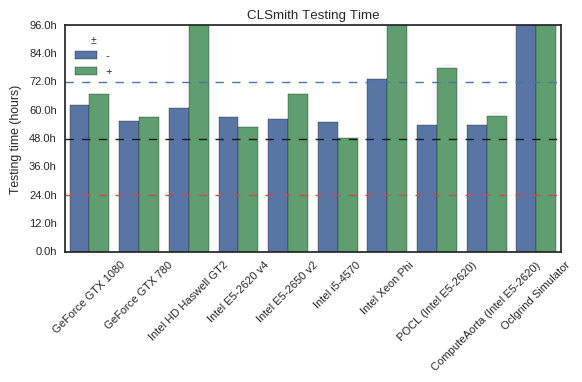

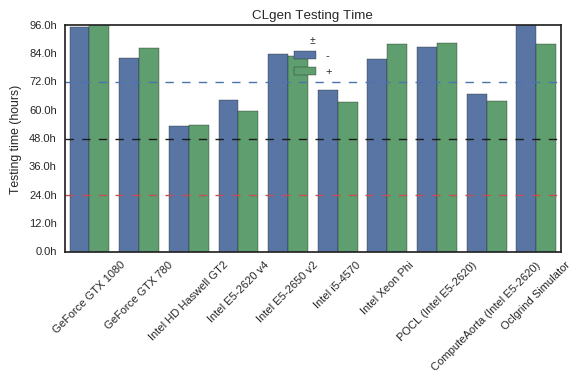

In [12]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 96 * 3600))
    plt.yticks(np.arange(0, 100 * 3600, 12 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

## Number of Results

Plot the number of results for each configuration.

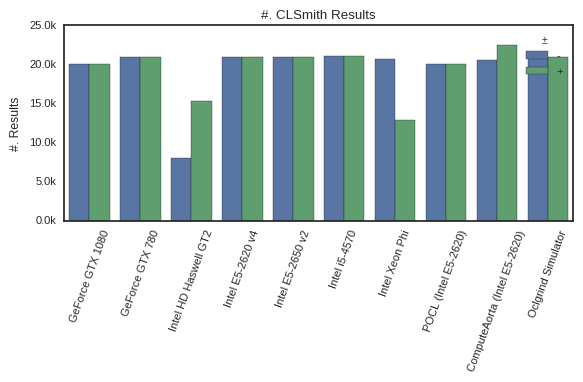

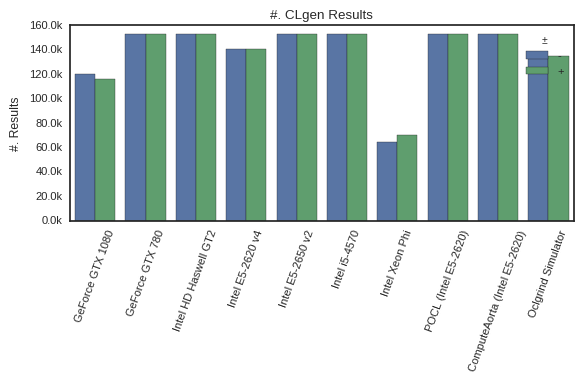

In [14]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("#. Results")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "CLgen results", "#. CLgen Results")

## Testbeds

In [15]:
total_time, total_submitted = 0, 0

def get_platform_stats(s, testbed: Testbed):
    global total_time
    global total_submitted
    num_submitted = s.query(sql.sql.func.count(BugReport.id))\
        .filter(BugReport.testbed_id == testbed.id).scalar() or 0

    # Total time running CLgen tests:
    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)
    
    # Total time running CLgen reductions:
    reduction_time = s.query(sql.sql.func.sum(CLgenReduction.runtime)).join(CLgenResult)\
        .filter(CLgenResult.testbed_id == testbed.id).scalar() or 0
    
    # Total time from unstructured testing results:
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).scalar() or 0
    other_runtimes = sum(get_runtime(table) for table in [coCLgenResult, cl_launcherCLgenResult])

    testing_time = clgen_time + reduction_time + other_runtimes

    total_time += testing_time
    total_submitted += num_submitted
    
    return testing_time, num_submitted


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    d["Open Source?"] = "Yes" if testbed.open_source else ""
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d


def get_testbeds_table():
    rows = []
    with Session(commit=False) as s:
        rows += [get_row(s, *x) for x in CONFIGURATIONS]
    return pd.DataFrame(rows)

testbeds_table = get_testbeds_table()

!cd ~/docs/paper-project_b/ && git pull --rebase
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllllL{{1cm}} | rR{{1.4cm}} }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Open Source?}} & \\textbf{{Testing time}} & \\textbf{{Bug Reports Submitted}} \\\\
\\midrule""", file=outfile)
    for _, row in testbeds_table.iterrows():
        print(" & ".join([str(x) for x in row]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
testbeds_table

Current branch master is up to date.
[master e016244] auto: build/tab/platforms.tex
 1 file changed, 6 insertions(+), 6 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 483 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   53071b8..e016244  master -> master


,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Open Source?,Testing time,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,,200 hours,8
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,,168 hours,1
2,3,Beignet,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,Yes,108 hours,13
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,,130 hours,6
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,,173 hours,1
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,,133 hours,5
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,,176 hours,3
7,8,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 64bit,CPU,Yes,181 hours,22
8,9,ComputeAorta,ComputeAorta (Intel E5-2620),1.14,1.2,Ubuntu 16.04 64bit,CPU,,131 hours,1
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,Yes,188 hours,7


In [16]:
total_hours = total_time / 3600
print(f"Total testing time: {total_hours:.1f}")
print(f"Total submitted: {total_submitted}")

Total testing time: 1587.2
Total submitted: 67


In [17]:
%run mkmegatable.ipy

Current branch master is up to date.

Generating classifications table ...
  Totals CLSmith {'w': 51, 'bf': 4719, 'bc': 6557, 'bto': 6978, 'c': 1110, 'to': 202, 'pass': 265460}
  Totals CLgen {'w': 69, 'bf': 51, 'bc': 7040, 'bto': 860, 'c': 252, 'to': 67, 'pass': 1812972}
  GeForce GTX 1080 CLSmith True {'w': 2, 'c': 2, 'to': 7, 'pass': 15621}
  GeForce GTX 1080 CLgen True {'w': 5, 'bf': 3, 'bc': 27, 'to': 4, 'pass': 62101}
  GeForce GTX 1080 CLSmith False {'w': 9, 'bto': 71, 'c': 6, 'to': 6, 'pass': 14001}
  GeForce GTX 1080 CLgen False {'w': 7, 'bf': 1, 'bc': 20, 'bto': 1, 'to': 3, 'pass': 57358}
  GeForce GTX 780 CLSmith True {'w': 5, 'c': 28, 'to': 13, 'pass': 18207}
  GeForce GTX 780 CLgen True {'w': 9, 'bf': 3, 'bc': 27, 'to': 3, 'pass': 87126}
  GeForce GTX 780 CLSmith False {'w': 3, 'bc': 26, 'bto': 14, 'to': 10, 'pass': 17644}
  GeForce GTX 780 CLgen False {'w': 9, 'bf': 1, 'bc': 32, 'bto': 1, 'to': 7, 'pass': 82659}
  Intel HD Haswell GT2 CLSmith True {'w': 3, 'bc': 2714, 'bt

## Runtimes

In [168]:
# delete cached result:
!rm -fv ../data/difftest/runtimes.csv

removed '../data/difftest/runtimes.csv'


In [169]:
import math

def get_runtimes_table():
    """ get runtimes of test case generation, execution, and reduction. cache results to file """
    cachepath = "../data/difftest/runtimes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Runtime (s)": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Source", "Name", "Runtime (s)", sep=',', file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    q = s.query(tables.results.runtime,
                                tables.programs.runtime)\
                        .join(tables.meta)\
                        .join(tables.testcases)\
                        .join(tables.programs)\
                        .filter(tables.meta.cumtime < TIME_LIMIT)

                    name = "DeepSmith" if tables.name == "CLgen" else tables.name
                    for runtime, generation_time in q:
                        if generation_time < TIMEOUT:
                            print(name, "Generation", generation_time, sep=',', file=outfile)
                        if runtime < TIMEOUT:
                            print(name, "Execution", runtime, sep=',', file=outfile)

            return get_runtimes_table()

runtimes_table = get_runtimes_table()
print("loaded", len(runtimes_table), "runtimes")

cached now (2017-08-11 14:27:01.636778)
loaded 4164674 runtimes


In [170]:
def avg_time(source, name):
    vals = runtimes_table[(runtimes_table["Source"] == source) & (runtimes_table["Name"] == name)]["Runtime (s)"].values
    vals = vals[~np.isnan(vals)]   # FIXME: NaN in DeepSmith Execution time?
    return vals.mean()
    
clsmith_avgs = np.array([
    avg_time("CLSmith", "Generation"),
    avg_time("CLSmith", "Execution"),
])
clgen_avgs = np.array([
    avg_time("DeepSmith", "Generation"),
    avg_time("DeepSmith", "Execution"),
])

total_speedup = (clsmith_avgs[0] + clsmith_avgs[1]) / (clgen_avgs[0] + clgen_avgs[1])
print(f"Total speedup is {total_speedup:.2f}x")

speedups = clsmith_avgs / clgen_avgs
generation_speedup, execution_speedup = speedups
print(f"DeepSmith generation is {generation_speedup:.2f}x faster than CLSmith")
print(f"DeepSmith execution is {execution_speedup:.2f}x faster than CLSmith")

Total speedup is 3.03x
DeepSmith generation is 2.45x faster than CLSmith
DeepSmith execution is 4.45x faster than CLSmith


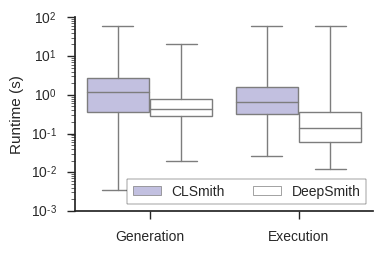

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/runtimes.pdf
[master 9e9d65b] auto: build/img/runtimes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 438 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   c254dcb..9e9d65b  master -> master


In [102]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.85, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='lower right', ncol=2)
    ax.get_legend().draw_frame(True)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 2.7))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 2.7))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Comparison to CLSmith

In [90]:
!rm -fv ../data/difftest/kernel-sizes.csv

removed '../data/difftest/kernel-sizes.csv'


In [119]:
def get_kernel_sizes(s: session_t, tables: Tableset, outfile):
    q = s.query(tables.results.id, tables.programs.size)\
            .join(tables.meta)\
            .join(tables.testcases)\
            .join(tables.programs)\
            .filter(tables.meta.cumtime < TIME_LIMIT)
    name = "DeepSmith" if tables.name == "CLgen" else tables.name
    for classification, size in q:
        print("Kernel", size, name, sep=",", file=outfile)

def get_kernel_sizes_table():
    cachepath = "../data/difftest/kernel-sizes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Size": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Classification", "Size", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    get_kernel_sizes(s, tables, outfile)

        return get_kernel_sizes_table()

kernel_sizes_table = get_kernel_sizes_table()
print("loaded", len(kernel_sizes_table), "line counts")

removed '../data/difftest/kernel-sizes.csv'
cached now (2017-08-09 11:47:28.780507)
loaded 2106388 line counts


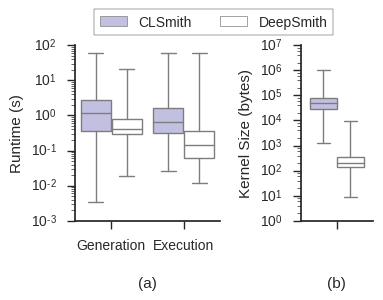

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/vs-clsmith.pdf
[master 81710ed] auto: build/img/vs-clsmith.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 3.31 KiB | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   0bd6384..81710ed  master -> master


In [161]:
from matplotlib import gridspec
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.85, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution"])

    plt.title("a", color="white")
    
    # Y axis
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("\n(a)")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='lower right', ncol=2)
    ax.legend().set_visible(False)
    
    # Border
    sns.despine(ax=ax)


def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Size", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette)#, order=["bc", "bto", "bf", "c", "w"])

    plt.title("a", color="white")
    
    # Y axis
    plt.ylabel("Kernel Size (bytes)")
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("\n(b)")
    plt.xticks([0], ['abc'], color='white')
    
    # Legend
    ax.legend().set_visible(False)
    
    # Border
    sns.despine(ax=ax)

def plot_both(*args, **kwargs):
    fig = plt.figure() 
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])

    plot_runtimes(runtimes_table)

    ax1 = plt.subplot(gs[1])
    plot_kernel_sizes(kernel_sizes_table)

    # Legend
    plt.legend(loc=(-2.85, 1.06), ncol=2)
    ax1.get_legend().set_title("")
    ax1.get_legend().draw_frame(True)

    viz.finalise(*args, **kwargs, figsize=(4, 3), tight_layout=False)

plot_both()

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_both(fs.path("~/docs/paper-project_b/build/img/vs-clsmith.pdf"))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/vs-clsmith.pdf" && git push

## Kernel Sizes

In [73]:
def get_kernel_sizes(s: session_t, tables: Tableset, outfile):
    q = s.query(tables.classifications.classification, tables.programs.size)\
            .join(tables.results)\
            .join(tables.meta)\
            .join(tables.testcases)\
            .join(tables.programs)\
            .filter(tables.meta.cumtime < TIME_LIMIT)
    name = "DeepSmith" if tables.name == "CLgen" else tables.name
    for classification, size in q:
        print(CLASSIFICATIONS[classification], size, name, sep=",", file=outfile)

def get_kernel_sizes_table():
    cachepath = "../data/difftest/kernel-sizes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Size": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Classification", "Size", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    get_kernel_sizes(s, tables, outfile)

        return get_kernel_sizes_table()

kernel_sizes_table = get_kernel_sizes_table()
print("loaded", len(kernel_sizes_table), "line counts")

cached now (2017-08-09 11:23:35.976192)
loaded 27687 line counts


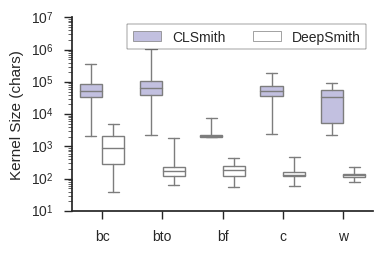

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/kernel-sizes.pdf
[master 81fea13] auto: build/img/kernel-sizes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 3.13 KiB | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   5a176e0..81fea13  master -> master


In [74]:
def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Size", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["bc", "bto", "bf", "c", "w"])

    # Y axis
    plt.ylabel("Kernel Size (chars)")
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper right', ncol=2)
    ax.get_legend().draw_frame(True)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
figsize = (4, 2.7)
plot_kernel_sizes(kernel_sizes_table, figsize=figsize)

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=figsize)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Compiler Crashes

In [66]:
!rm -fv ../data/difftest/compiler-crashes.csv

removed '../data/difftest/compiler-crashes.csv'


In [67]:
def get_bcs(s, tables, outfile):
    q = s.query(tables.meta.cumtime / 3600, TestbedConfig.num)\
        .join(tables.results)\
        .join(TestbedConfig, TestbedConfig.id == tables.results.testbed_id)\
        .filter(tables.results.outcome == OUTCOMES_TO_INT["bc"],
                tables.meta.cumtime < 48 * 3600,
                tables.results.testbed_id != 13)\
        .order_by(tables.meta.cumtime)
    for cumtime, num in q:
        print(num, cumtime, tables.name, sep=",", file=outfile)

def get_bcs_table():
    cachepath = "../data/difftest/compiler-crashes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Timestamp": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Configuration", "Timestamp", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                get_bcs(s, CLSMITH_TABLES, outfile)
                get_bcs(s, CLGEN_TABLES, outfile)
            return get_bcs_table()

bcs_table = get_bcs_table()

cached now (2017-08-09 10:59:51.636033)


## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push

In [114]:
def get_outcomes_df_for_source(s: session_t, tables: Tableset, time_limit: int):
    q = s.execute(f"""
SELECT num, device, optimizations, outcome, COUNT(*)
FROM {tables.results.__tablename__} results
INNER JOIN {tables.meta.__tablename__} meta ON results.id = meta.id
INNER JOIN {tables.testcases.__tablename__} testcases ON results.testcase_id = testcases.id
INNER JOIN {tables.params.__tablename__} params ON testcases.params_id = params.id
INNER JOIN Configurations ON results.testbed_id = Configurations.id
INNER JOIN Testbeds ON results.testbed_id = Testbeds.id
WHERE cumtime < {time_limit}
GROUP BY num, device, outcome, optimizations
ORDER BY num, outcome, optimizations;
""")
    return pd.DataFrame([[tables.name] + list(row) for row in q],
                        columns=["source", "num", "device", "optimizations", "outcome", "count"])


def get_outcomes_df(s: session_t, time_limit: int):
    clsmith_table = get_outcomes_df_for_source(s, CLSMITH_TABLES, time_limit)
    clgen_table = get_outcomes_df_for_source(s, CLGEN_TABLES, time_limit)
    return pd.concat((clsmith_table, clgen_table))


def get_classifications_df_for_source(s: session_t, tables: Tableset, time_limit: int):
    q = s.execute(f"""
SELECT num, device, optimizations, classification, COUNT(*)
FROM {tables.results.__tablename__} results
INNER JOIN {tables.classifications} classifications ON results.id = classifications.id
INNER JOIN {tables.meta.__tablename__} meta ON results.id = meta.id
INNER JOIN {tables.testcases.__tablename__} testcases ON results.testcase_id = testcases.id
INNER JOIN {tables.params.__tablename__} params ON testcases.params_id = params.id
INNER JOIN Configurations ON results.testbed_id = Configurations.id
INNER JOIN Testbeds ON results.testbed_id = Testbeds.id
WHERE cumtime < {time_limit}
GROUP BY num, device, classification, optimizations
ORDER BY num, classification, optimizations;
""")
    return pd.DataFrame([[tables.name] + list(row) for row in q],
                        columns=["source", "num", "device", "optimizations", "classification", "count"])


def get_classifications_df(s: session_t, time_limit: int):
    clsmith_table = get_classifications_df_for_source(s, CLSMITH_TABLES, time_limit)
    clgen_table = get_classifications_df_for_source(s, CLGEN_TABLES, time_limit)
    return pd.concat((clsmith_table, clgen_table))